In [11]:
# Cell 1: Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.svm import SVC
import seaborn as sns

In [12]:
# Cell 2: Scratch SVM Classifier
class ScratchSVMClassifier():
    """
    Scratch implementation of SVM classifier

    Parameters
    ----------
    num_iter : int
        Number of iterations
    lr : float
        Learning rate
    kernel : str
        Kernel type: linear or polynomial
    threshold : float
        Threshold for selecting support vectors
    verbose : bool
        Whether to output the learning process

    Attributes
    ----------
    n_support_vectors : int
        Number of support vectors
    index_support_vectors : ndarray
        Indices of support vectors
    X_sv : ndarray
        Features of support vectors
    lam_sv : ndarray
        Lagrange multipliers of support vectors
    y_sv : ndarray
        Labels of support vectors
    """

    def __init__(self, num_iter=1000, lr=0.001, kernel='linear', threshold=1e-5, verbose=False):
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.gamma = 1.0  # For polynomial kernel
        self.coef0 = 0
        self.degree = 3

    def _kernel_function(self, x1, x2):
        if self.kernel == 'linear':
            return np.dot(x1, x2)
        elif self.kernel == 'poly':
            return (self.gamma * np.dot(x1, x2) + self.coef0) ** self.degree
        else:
            raise ValueError("Kernel not supported. Use 'linear' or 'poly'")

    def _compute_gradient(self, X, y, lambda_vec):
        n_samples = X.shape[0]
        gradient = np.zeros(n_samples)
        for i in range(n_samples):
            sum_term = 0
            for j in range(n_samples):
                sum_term += lambda_vec[j] * y[i] * y[j] * self._kernel_function(X[i], X[j])
            gradient[i] = 1 - sum_term
        return gradient

    def fit(self, X, y, X_val=None, y_val=None):
        # Convert labels to ±1
        y_ = y.copy()
        y_[y_ == 0] = -1
        y = y_
        
        n_samples, n_features = X.shape
        self.X_ = X
        self.y = y.reshape(-1, 1)
        self.lambda_vec = np.zeros(n_samples)
        self.train_loss = []
        self.val_accuracy = []

        for epoch in range(self.iter):
            gradient = self._compute_gradient(X, y, self.lambda_vec)
            self.lambda_vec += self.lr * gradient
            self.lambda_vec = np.maximum(self.lambda_vec, 0)

            # Dual loss
            loss = 0
            for i in range(n_samples):
                loss += self.lambda_vec[i]
                for j in range(n_samples):
                    loss -= 0.5 * self.lambda_vec[i] * self.lambda_vec[j] * y[i] * y[j] * self._kernel_function(X[i], X[j])
            self.train_loss.append(-loss)

            # Support vectors
            sv_indices = self.lambda_vec > self.threshold
            self.index_support_vectors = np.where(sv_indices)[0]
            self.n_support_vectors = len(self.index_support_vectors)
            self.X_sv = X[sv_indices]
            self.lam_sv = self.lambda_vec[sv_indices].reshape(-1, 1)
            self.y_sv = y[sv_indices].reshape(-1, 1)

            # Validation accuracy
            if X_val is not None and y_val is not None:
                y_val_pred = self.predict(X_val)
                val_acc = accuracy_score(y_val, y_val_pred)
                self.val_accuracy.append(val_acc)

            if self.verbose and epoch % 100 == 0:
                if X_val is not None and y_val is not None:
                    print(f"Iteration {epoch}: Loss = {-loss:.4f}, Val Accuracy = {val_acc:.4f}, SV = {self.n_support_vectors}")
                else:
                    print(f"Iteration {epoch}: Loss = {-loss:.4f}, SV = {self.n_support_vectors}")

    def predict(self, X):
        n_samples = X.shape[0]
        y_pred = np.zeros(n_samples)
        for i in range(n_samples):
            decision_value = sum(self.lam_sv[j] * self.y_sv[j] * self._kernel_function(X[i], self.X_sv[j])
                                 for j in range(self.n_support_vectors))
            y_pred[i] = 1 if decision_value >= 0 else 0
        return y_pred

    def decision_function(self, X):
        n_samples = X.shape[0]
        decision_values = np.zeros(n_samples)
        for i in range(n_samples):
            for j in range(self.n_support_vectors):
                decision_values[i] += self.lam_sv[j] * self.y_sv[j] * self._kernel_function(X[i], self.X_sv[j])
        return decision_values


In [13]:
# Cell 3: Problem 4 - Learning and Estimation
print("=== Problem 4: Learning and Estimation ===")

# Binary classification dataset
X, y = make_blobs(n_samples=100, centers=2, random_state=42, cluster_std=1.5)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

# Scratch SVM
scratch_svm = ScratchSVMClassifier(num_iter=1000, lr=0.001, kernel='linear', verbose=True)
scratch_svm.fit(X_train, y_train, X_val, y_val)

y_pred_scratch = scratch_svm.predict(X_test)

# Scikit-learn SVM
sklearn_svm = SVC(kernel='linear', random_state=42)
sklearn_svm.fit(X_train, y_train)
y_pred_sklearn = sklearn_svm.predict(X_test)

# Metrics
accuracy_scratch = accuracy_score(y_test, y_pred_scratch)
precision_scratch = precision_score(y_test, y_pred_scratch)
recall_scratch = recall_score(y_test, y_pred_scratch)

accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)
precision_sklearn = precision_score(y_test, y_pred_sklearn)
recall_sklearn = recall_score(y_test, y_pred_sklearn)

print("\n=== Performance Comparison ===")
print("Scratch SVM:")
print(f"  Accuracy:  {accuracy_scratch:.4f}")
print(f"  Precision: {precision_scratch:.4f}")
print(f"  Recall:    {recall_scratch:.4f}")
print(f"  Support vectors: {scratch_svm.n_support_vectors}")

print("\nScikit-learn SVM:")
print(f"  Accuracy:  {accuracy_sklearn:.4f}")
print(f"  Precision: {precision_sklearn:.4f}")
print(f"  Recall:    {recall_sklearn:.4f}")
print(f"  Support vectors: {len(sklearn_svm.support_)}")


=== Problem 4: Learning and Estimation ===
Training: (64, 2), Validation: (16, 2), Test: (20, 2)
Iteration 0: Loss = -0.0139, Val Accuracy = 0.9375, SV = 64
Iteration 100: Loss = 0.2310, Val Accuracy = 0.8125, SV = 40
Iteration 200: Loss = 0.2305, Val Accuracy = 0.8125, SV = 36
Iteration 300: Loss = 0.2633, Val Accuracy = 0.8750, SV = 36
Iteration 400: Loss = 0.2944, Val Accuracy = 0.8750, SV = 35
Iteration 500: Loss = 0.3216, Val Accuracy = 0.8750, SV = 35
Iteration 600: Loss = 0.3331, Val Accuracy = 0.8750, SV = 35
Iteration 700: Loss = 0.3385, Val Accuracy = 0.8750, SV = 35
Iteration 800: Loss = 0.3418, Val Accuracy = 0.8750, SV = 35
Iteration 900: Loss = 0.3442, Val Accuracy = 0.8750, SV = 35

=== Performance Comparison ===
Scratch SVM:
  Accuracy:  0.4500
  Precision: 0.4500
  Recall:    1.0000
  Support vectors: 13

Scikit-learn SVM:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  Support vectors: 3



=== Problem 5: Decision Boundary Visualization ===


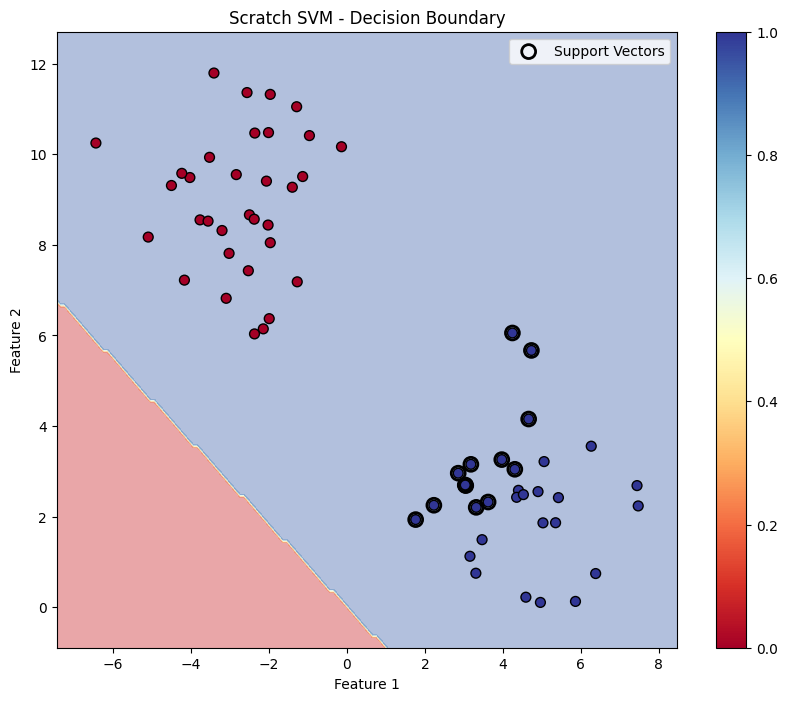

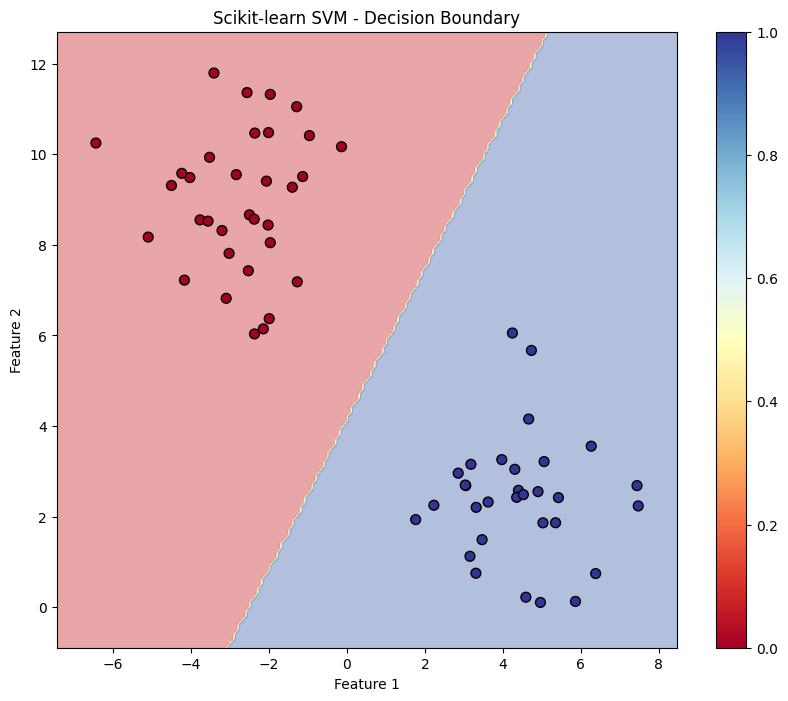

In [14]:
# Cell 4: Problem 5 - Decision Boundary Visualization
print("\n=== Problem 5: Decision Boundary Visualization ===")

def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='k', s=50)
    
    if hasattr(model, 'X_sv'):
        plt.scatter(model.X_sv[:, 0], model.X_sv[:, 1], s=100, facecolors='none', edgecolors='k', linewidths=2, label='Support Vectors')
        plt.legend()
    
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(scatter)
    plt.show()

plot_decision_boundary(scratch_svm, X_train, y_train, "Scratch SVM - Decision Boundary")
plot_decision_boundary(sklearn_svm, X_train, y_train, "Scikit-learn SVM - Decision Boundary")



=== Problem 6: Polynomial Kernel ===


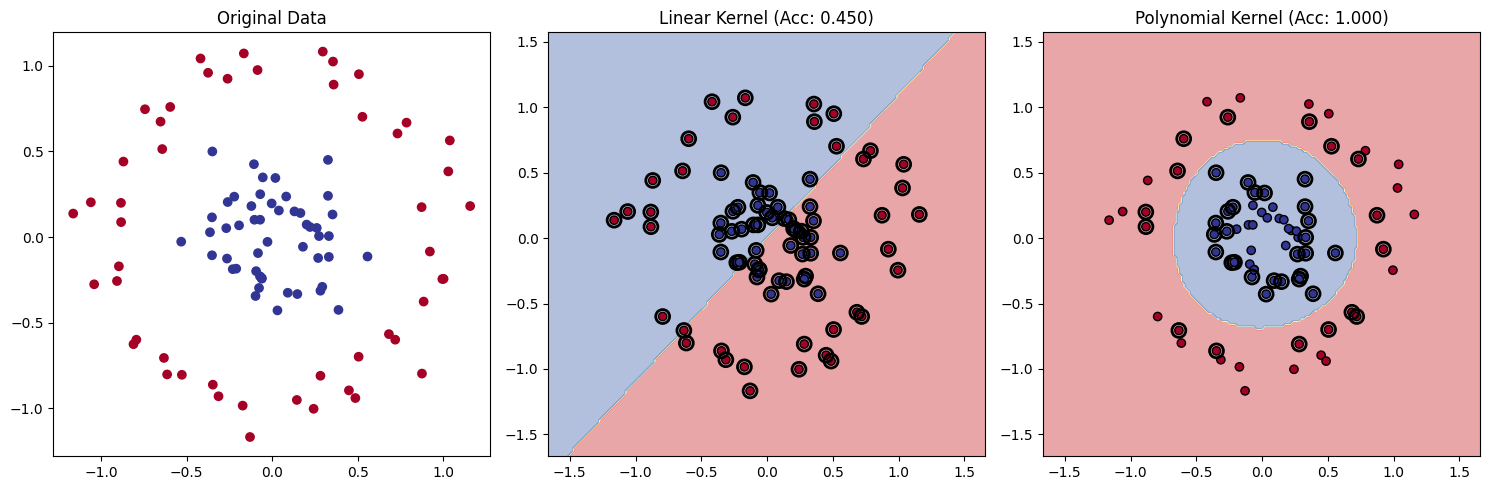

In [15]:
# Cell 5: Problem 6 - Polynomial Kernel
print("\n=== Problem 6: Polynomial Kernel ===")

X_circle, y_circle = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_circle, y_circle, test_size=0.2, random_state=42)

# Linear kernel (poor performance)
linear_svm = ScratchSVMClassifier(num_iter=1000, lr=0.001, kernel='linear', verbose=False)
linear_svm.fit(X_train_c, y_train_c)

# Polynomial kernel
poly_svm = ScratchSVMClassifier(num_iter=1000, lr=0.001, kernel='poly', verbose=False)
poly_svm.gamma = 1.0
poly_svm.coef0 = 1
poly_svm.degree = 3
poly_svm.fit(X_train_c, y_train_c)

y_pred_linear = linear_svm.predict(X_test_c)
y_pred_poly = poly_svm.predict(X_test_c)
acc_linear = accuracy_score(y_test_c, y_pred_linear)
acc_poly = accuracy_score(y_test_c, y_pred_poly)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_circle[:, 0], X_circle[:, 1], c=y_circle, cmap=plt.cm.RdYlBu)
plt.title("Original Data")

plt.subplot(1, 3, 2)
x_min, x_max = X_circle[:, 0].min() - 0.5, X_circle[:, 0].max() + 0.5
y_min, y_max = X_circle[:, 1].min() - 0.5, X_circle[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z_linear = linear_svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z_linear, alpha=0.4, cmap=plt.cm.RdYlBu)
plt.scatter(X_train_c[:, 0], X_train_c[:, 1], c=y_train_c, cmap=plt.cm.RdYlBu, edgecolors='k')
plt.scatter(linear_svm.X_sv[:, 0], linear_svm.X_sv[:, 1], s=100, facecolors='none', edgecolors='k', linewidths=2)
plt.title(f"Linear Kernel (Acc: {acc_linear:.3f})")

plt.subplot(1, 3, 3)
Z_poly = poly_svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z_poly, alpha=0.4, cmap=plt.cm.RdYlBu)
plt.scatter(X_train_c[:, 0], X_train_c[:, 1], c=y_train_c, cmap=plt.cm.RdYlBu, edgecolors='k')
plt.scatter(poly_svm.X_sv[:, 0], poly_svm.X_sv[:, 1], s=100, facecolors='none', edgecolors='k', linewidths=2)
plt.title(f"Polynomial Kernel (Acc: {acc_poly:.3f})")

plt.tight_layout()
plt.show()


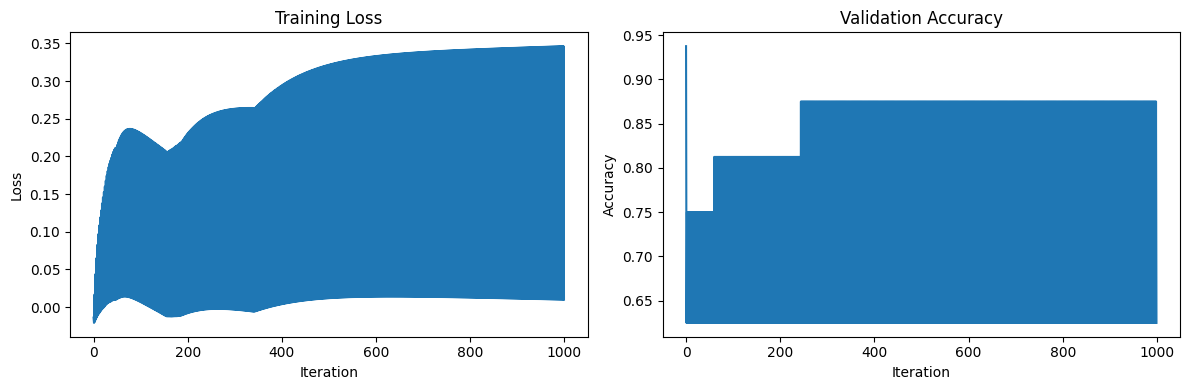

In [16]:
# Cell 6: Training History
if hasattr(scratch_svm, 'train_loss'):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(scratch_svm.train_loss)
    plt.title('Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    
    if hasattr(scratch_svm, 'val_accuracy'):
        plt.subplot(1, 2, 2)
        plt.plot(scratch_svm.val_accuracy)
        plt.title('Validation Accuracy')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.show()


In [17]:
# Cell 7: Assignment Summary
print("\n=== Assignment Summary ===")
print("✓ Problem 1: Gradient descent for Lagrange multipliers implemented")
print("✓ Problem 2: Support vector determination implemented")
print("✓ Problem 3: Prediction function implemented")
print("✓ Problem 4: Compared with scikit-learn SVM")
print("✓ Problem 5: Decision boundaries visualized")
print("✓ Problem 6: Polynomial kernel implemented")



=== Assignment Summary ===
✓ Problem 1: Gradient descent for Lagrange multipliers implemented
✓ Problem 2: Support vector determination implemented
✓ Problem 3: Prediction function implemented
✓ Problem 4: Compared with scikit-learn SVM
✓ Problem 5: Decision boundaries visualized
✓ Problem 6: Polynomial kernel implemented
